In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shipt-delivery/TS.csv
/kaggle/input/mock-data/MOCK_DATA.csv


In [83]:
!pip install chart_studio

In [84]:
import pandasql as ps

from datetime import datetime

import chart_studio.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
from plotly import figure_factory as FF
import plotly.express as px

from fbprophet import Prophet

# Objective:

Something critical to our business is understanding what <font color='red'> supply and demand might look like in the near future </font> in order to plan for hiring and shopper activation activities. Let’s say that you’ve collected the data from the ETL section for the <font color='red'> period of a month </font>:

a. How would you approach forecasting our expected daily supply and demand at the market level?

b. How would you incorporate information about the <font color='red'> spatial hierarchy </font> of supply and demand (i.e. neighborhoods roll up into a single market) and information about the “true” availability of supply (i.e. shoppers who signup but always abandon) into your forecasting method?

c. How would you evaluate the validity and accuracy of your forecast?

## Response:

### Approach:
* Frame the Problem
* Gather Necessary Data
* EDA
* Data Cleaning
* Feature Engineering
* Build Models (including SOA: Neural Prophet from FB and Hierarchical TS)
* Model Evaluation

## Frame the Problem

This is a Time Series prediction problem for supply and demand in three different markets (2 different graphs with 3 markets per graph).

## Gather Necessary Data

Year's worth of data of delivery time window start times and number of available shoppers for those windows.

In [85]:
df = pd.read_csv('../input/shipt-delivery/TS.csv')
df

,Unnamed: 0,delivery_window_id,starts_at,market_name,neighborhood_name,order_id,shopper_id,abandoned
0,0,29675515,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,881966301,2253287,0
1,1,29675516,2017-03-01T01:00:00Z,Philadelphia,Philadelphia West,882796335,2253287,0
2,2,29675517,2017-03-01T02:00:00Z,Philadelphia,Philadelphia West,882899505,2253287,0
3,3,29675518,2017-03-01T03:00:00Z,Philadelphia,Philadelphia West,883045539,2253287,0
4,4,29678563,2017-03-01T00:00:00Z,New York NY,Upper East Side,882241953,704789,1
...,...,...,...,...,...,...,...,...
2084,2084,31569629,2017-04-01T22:00:00Z,San Francisco,Financial District,944475750,3539999,0
2085,2085,31569914,2017-04-01T19:00:00Z,San Francisco,Pacific Heights / Marina,944030523,3539999,0
2086,2086,31582016,2017-04-01T22:00:00Z,Philadelphia,Chestnut Hill,944621100,2533979,0
2087,2087,31582039,2017-04-01T21:00:00Z,Philadelphia,Center City,943445190,5619176,0


For this problem, only need time stamp, demand (no of orders) and supply (no unique shoppers available who can actually fulfill orders).

In [86]:
ps.sqldf("select* from df")

,Unnamed: 0,delivery_window_id,starts_at,market_name,neighborhood_name,order_id,shopper_id,abandoned
0,0,29675515,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,881966301,2253287,0
1,1,29675516,2017-03-01T01:00:00Z,Philadelphia,Philadelphia West,882796335,2253287,0
2,2,29675517,2017-03-01T02:00:00Z,Philadelphia,Philadelphia West,882899505,2253287,0
3,3,29675518,2017-03-01T03:00:00Z,Philadelphia,Philadelphia West,883045539,2253287,0
4,4,29678563,2017-03-01T00:00:00Z,New York NY,Upper East Side,882241953,704789,1
...,...,...,...,...,...,...,...,...
2084,2084,31569629,2017-04-01T22:00:00Z,San Francisco,Financial District,944475750,3539999,0
2085,2085,31569914,2017-04-01T19:00:00Z,San Francisco,Pacific Heights / Marina,944030523,3539999,0
2086,2086,31582016,2017-04-01T22:00:00Z,Philadelphia,Chestnut Hill,944621100,2533979,0
2087,2087,31582039,2017-04-01T21:00:00Z,Philadelphia,Center City,943445190,5619176,0


In [87]:
#demand time series data
demand = ps.sqldf("select starts_at, market_name, neighborhood_name, count(order_id) from df group by 1, 2, 3")
demand

,starts_at,market_name,neighborhood_name,count(order_id)
0,2017-03-01T00:00:00Z,New York NY,Staten Island,1
1,2017-03-01T00:00:00Z,New York NY,Upper East Side,1
2,2017-03-01T00:00:00Z,Philadelphia,Chestnut Hill,1
3,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,1
4,2017-03-01T00:00:00Z,San Francisco,Financial District,1
...,...,...,...,...
2084,2017-04-01T23:00:00Z,New York NY,Downtown Brooklyn,1
2085,2017-04-01T23:00:00Z,New York NY,Staten Island,1
2086,2017-04-01T23:00:00Z,New York NY,Upper West Side,1
2087,2017-04-01T23:00:00Z,Philadelphia,Philadelphia West,1


2089 orders

In [88]:
#supply data
ps.sqldf("select starts_at, count(distinct shopper_id) from df where abandoned = 0 group by 1")

,starts_at,count(distinct shopper_id)
0,2017-03-01T00:00:00Z,3
1,2017-03-01T01:00:00Z,4
2,2017-03-01T02:00:00Z,5
3,2017-03-01T03:00:00Z,3
4,2017-03-01T04:00:00Z,2
...,...,...
502,2017-04-01T19:00:00Z,3
503,2017-04-01T20:00:00Z,4
504,2017-04-01T21:00:00Z,3
505,2017-04-01T22:00:00Z,4


507 fulfilled delivery windows by shoppers needing to do multiple orders to meet the demand.

In [89]:
#supply time series data
supply = ps.sqldf("select starts_at, market_name, neighborhood_name,count(distinct shopper_id) from df where abandoned = 0 group by 1, 2, 3")
supply

,starts_at,market_name,neighborhood_name,count(distinct shopper_id)
0,2017-03-01T00:00:00Z,New York NY,Staten Island,1
1,2017-03-01T00:00:00Z,Philadelphia,Chestnut Hill,1
2,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,1
3,2017-03-01T00:00:00Z,San Francisco,Financial District,1
4,2017-03-01T01:00:00Z,New York NY,Downtown Brooklyn,1
...,...,...,...,...
1353,2017-04-01T22:00:00Z,San Francisco,SoMa / Castro,1
1354,2017-04-01T23:00:00Z,New York NY,Downtown Brooklyn,1
1355,2017-04-01T23:00:00Z,New York NY,Staten Island,1
1356,2017-04-01T23:00:00Z,Philadelphia,Philadelphia West,1


## EDA

Let's look at supply and demand's hourly distribution that will be represented by supply's data since both supply and demand share same time stamp data.

In [90]:
supply['starts_at'] =  pd.to_datetime(supply['starts_at'],
                              format='%Y-%m-%dT%H:%M:%SZ')

In [91]:
def hrs(row):
    return row.hour
supply.starts_at.apply(hrs).value_counts(normalize=1) #relative frequencies in desc order

18    0.083211
20    0.076583
19    0.076583
21    0.075847
22    0.072901
1     0.072901
17    0.068483
16    0.065538
23    0.063328
0     0.058174
2     0.057437
15    0.053019
14    0.046392
3     0.039764
4     0.034610
13    0.027246
12    0.011046
5     0.010309
11    0.002946
6     0.002209
7     0.001473
Name: starts_at, dtype: float64

In [92]:
s = supply.starts_at.apply(hrs)
s

0        0
1        0
2        0
3        0
4        1
        ..
1353    22
1354    23
1355    23
1356    23
1357    23
Name: starts_at, Length: 1358, dtype: int64

In [93]:
fig = px.bar(x=s.value_counts().index, y=s.value_counts().values,title="Delivery Window Start Time Hours Distribution")
fig.layout.hovermode='closest'
fig.update_xaxes(title_text='Hours')
fig.update_yaxes(title_text='Count')
fig.show()

Looks like dummy data since lot of deliveries are happening in very early morning time when people are asleep. I would expect little more deliveries happening between 5 am and 11 am since people are starting their work shift or already in them/active.

Now let us look at market and neighborhood distributions from demand and supply.

In [94]:
fig2 = px.bar(x=demand['market_name'].value_counts().index, y=demand['market_name'].value_counts().values,title="Demand Side Market Distribution")
fig2.layout.hovermode='closest'
fig2.update_traces(marker_color='purple')
fig2.update_xaxes(title_text='Market')
fig2.update_yaxes(title_text='Count')
fig2.show()

New York's demand is the highest--more mature market.

In [95]:
fig3 = px.bar(x=supply['market_name'].value_counts().index, y=supply['market_name'].value_counts().values,title="Supply Side Market Distribution")
fig3.layout.hovermode='closest'
fig3.update_traces(marker_color='pink')
fig3.update_xaxes(title_text='Market')
fig3.update_yaxes(title_text='Count')
fig3.show()

New York is the dominant in supply as well.

In [96]:
fig4 = px.bar(x=demand['neighborhood_name'].value_counts().index, y=demand['neighborhood_name'].value_counts().values,title="Demand Side Neighborhood Distribution")
fig4.layout.hovermode='closest'
fig4.update_traces(marker_color='red')
fig4.update_xaxes(title_text='Neighborhood Name')
fig4.update_yaxes(title_text='Count')
fig4.show()

Top 5 in demand are Upper East Side, Financial District, Downtown Brooklyn, Philidelphia West and Staten Island.

In [97]:
#hover_name as bar arg inputs in tooltip
fig5 = px.bar(x=supply['neighborhood_name'].value_counts().index, y=supply['neighborhood_name'].value_counts().values,title="Supply Side Neighborhood Distribution")
fig5.layout.hovermode='closest'
fig5.update_traces(marker_color='orange')
fig5.update_xaxes(title_text='Neighborhood Name')
fig5.update_yaxes(title_text='Count')
fig5.show()

Supply side has the same top 5 neighborhoods, but ranked differently. So there may be some demand-supply disequilibrium.

In [98]:
#Demand cut by market with repsective counts
gb = demand.groupby('market_name')    
[gb.get_group(x) for x in gb.groups]

[                 starts_at  market_name  neighborhood_name  count(order_id)
 0     2017-03-01T00:00:00Z  New York NY      Staten Island                1
 1     2017-03-01T00:00:00Z  New York NY    Upper East Side                1
 5     2017-03-01T01:00:00Z  New York NY  Downtown Brooklyn                1
 6     2017-03-01T01:00:00Z  New York NY    Upper East Side                1
 9     2017-03-01T02:00:00Z  New York NY  Downtown Brooklyn                1
 ...                    ...          ...                ...              ...
 2077  2017-04-01T22:00:00Z  New York NY      Staten Island                1
 2078  2017-04-01T22:00:00Z  New York NY    Upper East Side                1
 2084  2017-04-01T23:00:00Z  New York NY  Downtown Brooklyn                1
 2085  2017-04-01T23:00:00Z  New York NY      Staten Island                1
 2086  2017-04-01T23:00:00Z  New York NY    Upper West Side                1
 
 [1084 rows x 4 columns],
                  starts_at   market_name  neigh

In [99]:
#Supply cut by market with repsective counts
gb2 = supply.groupby('market_name')    
[gb2.get_group(x) for x in gb2.groups]

[               starts_at  market_name  neighborhood_name  \
 0    2017-03-01 00:00:00  New York NY      Staten Island   
 4    2017-03-01 01:00:00  New York NY  Downtown Brooklyn   
 5    2017-03-01 01:00:00  New York NY    Upper East Side   
 8    2017-03-01 02:00:00  New York NY  Downtown Brooklyn   
 9    2017-03-01 02:00:00  New York NY      Staten Island   
 ...                  ...          ...                ...   
 1342 2017-04-01 20:00:00  New York NY      Staten Island   
 1345 2017-04-01 21:00:00  New York NY      Staten Island   
 1348 2017-04-01 22:00:00  New York NY      Staten Island   
 1354 2017-04-01 23:00:00  New York NY  Downtown Brooklyn   
 1355 2017-04-01 23:00:00  New York NY      Staten Island   
 
       count(distinct shopper_id)  
 0                              1  
 4                              1  
 5                              1  
 8                              1  
 9                              1  
 ...                          ...  
 1342         

# Models

### As first pass: Supply in aggregate to forecast and get model performane comparison. Next step is to do both Demand and Supply forecasting at market level.


## Prophet

Let's try Prophet first and later on try out Neural Prophet for kicks :D

In [100]:
supply_df = ps.sqldf("select starts_at, count(distinct shopper_id) from df where abandoned = 0 group by 1")
supply_df

,starts_at,count(distinct shopper_id)
0,2017-03-01T00:00:00Z,3
1,2017-03-01T01:00:00Z,4
2,2017-03-01T02:00:00Z,5
3,2017-03-01T03:00:00Z,3
4,2017-03-01T04:00:00Z,2
...,...,...
502,2017-04-01T19:00:00Z,3
503,2017-04-01T20:00:00Z,4
504,2017-04-01T21:00:00Z,3
505,2017-04-01T22:00:00Z,4


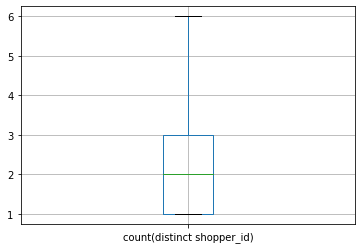

In [101]:
boxplot = supply_df.boxplot(column=['count(distinct shopper_id)'])

Median value is at 2. So expect to have mos predictons near this number and at lower end of range given boxplot.

## Data Cleaning

In [102]:
supply_df['starts_at'] = pd.to_datetime(supply_df['starts_at'],
                              format='%Y-%m-%dT%H:%M:%SZ')

In [103]:
supply_df.columns = ['ds', 'y']
supply_df.head()

,ds,y
0,2017-03-01 00:00:00,3
1,2017-03-01 01:00:00,4
2,2017-03-01 02:00:00,5
3,2017-03-01 03:00:00,3
4,2017-03-01 04:00:00,2


In [104]:
model = Prophet()
model.fit(supply_df)

In [105]:
ps.sqldf('select* from df order by 3') #month's worth only. so will start with making forecasts 30 days out 

,Unnamed: 0,delivery_window_id,starts_at,market_name,neighborhood_name,order_id,shopper_id,abandoned
0,0,29675515,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,881966301,2253287,0
1,4,29678563,2017-03-01T00:00:00Z,New York NY,Upper East Side,882241953,704789,1
2,7,29683435,2017-03-01T00:00:00Z,New York NY,Staten Island,882660162,3172091,0
3,13,29686264,2017-03-01T00:00:00Z,San Francisco,Financial District,882719499,3539999,0
4,19,29700187,2017-03-01T00:00:00Z,Philadelphia,Chestnut Hill,882721323,2253287,0
...,...,...,...,...,...,...,...,...
2084,2044,31548345,2017-04-01T23:00:00Z,New York NY,Downtown Brooklyn,943255323,3176162,0
2085,2051,31558953,2017-04-01T23:00:00Z,Philadelphia,Philadelphia West,941709711,2533979,0
2086,2068,31566801,2017-04-01T23:00:00Z,New York NY,Staten Island,944173878,3172091,0
2087,2074,31566873,2017-04-01T23:00:00Z,New York NY,Upper West Side,944763315,2831898,1


In [106]:
future = model.make_future_dataframe(periods=30)
future.tail()

,ds
532,2017-04-27 23:00:00
533,2017-04-28 23:00:00
534,2017-04-29 23:00:00
535,2017-04-30 23:00:00
536,2017-05-01 23:00:00


In [107]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
532,2017-04-27 23:00:00,2.212833,1.019073,3.462080
533,2017-04-28 23:00:00,2.218254,1.042391,3.448047
534,2017-04-29 23:00:00,2.477069,1.183228,3.764019
535,2017-04-30 23:00:00,2.259314,1.063494,3.559360
536,2017-05-01 23:00:00,2.182307,0.847725,3.336812


yhat are the predictions and most of them are 2 as expected.

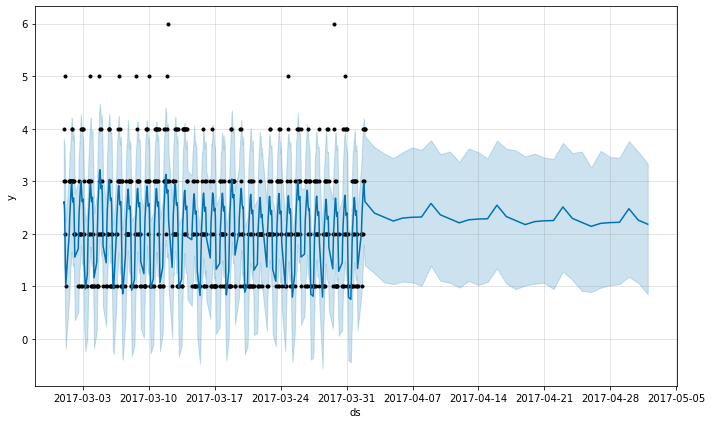

In [108]:
fig1 = model.plot(forecast)

* Black dots are the actual y values.
* Dark blue are the predictions (yhat).
* Light blue at top are yhat upper.
* Light blue at bottom are yhat lower.

Predictions are mostly between 2 and 3 with range between 1 and high end of 3's.

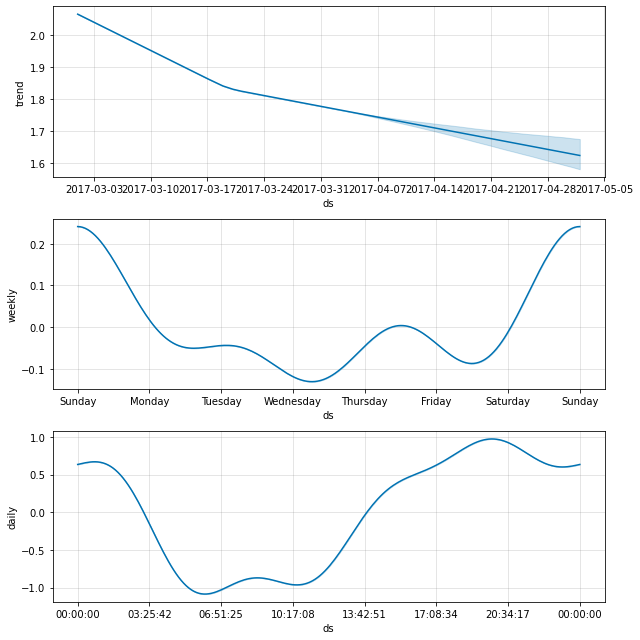

In [109]:
fig2 = model.plot_components(forecast)

* Looks like there is decline over a year's time span.
* On a weekly basis, looks lik midweek is where dip in shoppers' availability happens
* And on an hourly basis, the low end of availability is between 3 am and 1 pm as what was plotted earlier.

Now let us take a look at the prediction accuracy with some model performance reporting.

In [110]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model, initial = '20 days', horizon= '10 days')

In [111]:
df_pm = performance_metrics(df_cv)
df_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 23:00:00,1.187156,1.089567,0.903312,0.420874,0.459998,0.666667
1,1 days 00:00:00,1.303777,1.141830,0.989030,0.449032,0.459998,0.600000
2,1 days 01:00:00,1.303957,1.141909,0.989481,0.449257,0.459998,0.600000
3,1 days 02:00:00,1.376829,1.173383,1.054563,0.470155,0.459998,0.600000
4,1 days 03:00:00,1.295920,1.138385,0.991815,0.438780,0.441048,0.666667
...,...,...,...,...,...,...,...
137,9 days 20:00:00,0.788837,0.888165,0.700330,0.316275,0.341041,0.800000
138,9 days 21:00:00,0.923557,0.961019,0.755634,0.325639,0.343886,0.733333
139,9 days 22:00:00,0.905068,0.951351,0.745905,0.322396,0.343886,0.733333
140,9 days 23:00:00,1.111691,1.054367,0.804531,0.329705,0.343886,0.733333


The RMSE is understable given deviation (ylower and yupper) from predictions. Though let us see if we can get an improvement through implementing Neural Prophet.

## Neural Prophet

In [112]:
!pip install neuralprophet

In [113]:
from neuralprophet import NeuralProphet

In [114]:
m = NeuralProphet()
metrics = m.fit(supply_df, freq="D")
future = m.make_future_dataframe(supply_df, periods=30)
forecast = m.predict(future)

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 63


INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
Epoch[63/63]: 100%|██████████| 63/63 [00:06<00:00,  9.39it/s, SmoothL1Loss=0.0315, MAE=0.758, RegLoss=0]


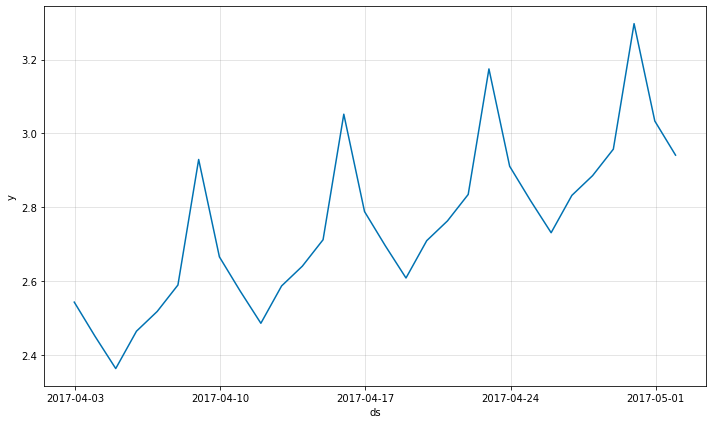

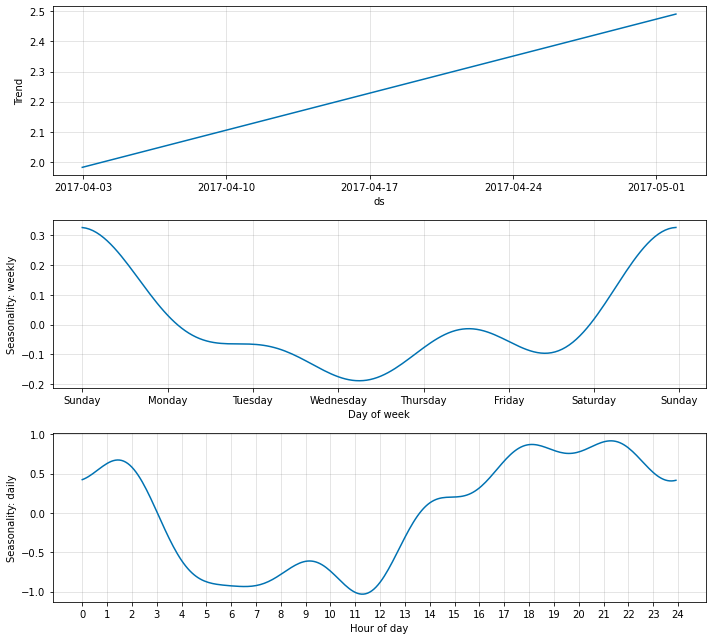

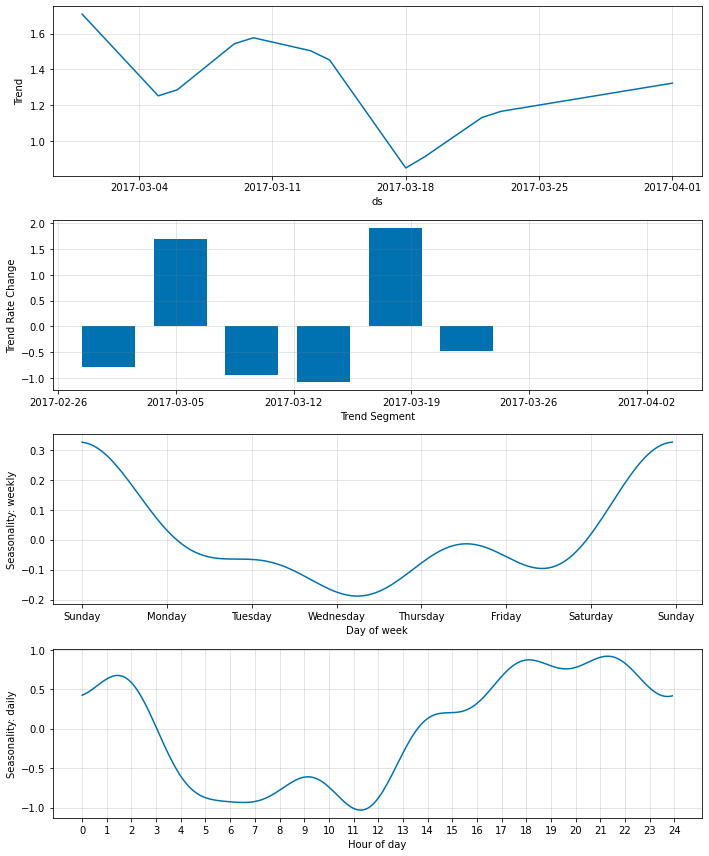

In [115]:
fig_forecast = m.plot(forecast)
fig_components = m.plot_components(forecast)
fig_model = m.plot_parameters()

* The first group of plots is for prediction (horizon) whereas the second group of plots is from the initial/training data.  

* It is clear that the Neural Net definitely captured more of the nuances in the data. Though it may have been excessive. Another thing to note is that the training data's yearly components have an upward trends whereas the normal Prophet one had downward trend. 

* Neural Prophet's week-to-week trend also predicted with greater range (up to 6). 

* Though the neural prophet captured more info, looks like the prediction may have been more off, but let us make sure with performance metrics.

In [116]:
metrics = m.fit(supply_df, freq="D", validate_each_epoch=True, valid_p=0.2)

Epoch[63/63]: 100%|██████████| 63/63 [00:05<00:00, 11.54it/s, SmoothL1Loss=0.029, MAE=0.727, RegLoss=0, MAE_val=1.03, SmoothL1Loss_val=0.0571]  


They used MAE here to account for outliers. So comparing regular Prophet MAE to Neural Prophet, see that MAE ranged from 0.6092029760977173 to 1.4588661228991116 whereas the Neural Prophet MAE was .726. Baseline Prophet had some clear wins. 

Though let us see if our forecasts can be better with other Time Series models.

## LightGBM: A Highly Efficient Gradient Boosting Decision Tree

[LightGBM](https://github.com/Microsoft/LightGBM/) is a gradient boosting framework that uses tree-based learning algorithms. [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting/) is an ensemble technique in which models are added to the ensemble sequentially and at each iteration a new model is trained with respect to the error of the whole ensemble learned so far. More detailed information about gradient boosting can be found in this [tutorial paper](http://https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full). Using this technique, LightGBM achieves great accuracy in many applications. Apart from this, it is designed to be distributed and efficient with the following advantages:

* Fast training speed and high efficiency.
* Low memory usage.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

Due to these advantages, LightGBM has been widely used in a lot of winning solutions of machine learning competitions.

In [117]:
!pip install lightgbm

In [118]:
import lightgbm as lgb

In [119]:
#Tr - 20 days. Test = 10 days
supply_df

,ds,y
0,2017-03-01 00:00:00,3
1,2017-03-01 01:00:00,4
2,2017-03-01 02:00:00,5
3,2017-03-01 03:00:00,3
4,2017-03-01 04:00:00,2
...,...,...
502,2017-04-01 19:00:00,3
503,2017-04-01 20:00:00,4
504,2017-04-01 21:00:00,3
505,2017-04-01 22:00:00,4


Need to decompose date time stamp into components: year, month, day, hours, minutes, seconds as features.

In [120]:
supply_df['year'] =  supply_df['ds'].dt.year
supply_df['month'] = supply_df['ds'].dt.month
supply_df['day'] = supply_df['ds'].dt.dayofweek
supply_df['hours'] = supply_df['ds'].dt.hour
supply_df['minutes'] = supply_df['ds'].dt.minute
supply_df['seconds'] = supply_df['ds'].dt.second

In [121]:
supply_df

,ds,y,year,month,day,hours,minutes,seconds
0,2017-03-01 00:00:00,3,2017,3,2,0,0,0
1,2017-03-01 01:00:00,4,2017,3,2,1,0,0
2,2017-03-01 02:00:00,5,2017,3,2,2,0,0
3,2017-03-01 03:00:00,3,2017,3,2,3,0,0
4,2017-03-01 04:00:00,2,2017,3,2,4,0,0
...,...,...,...,...,...,...,...,...
502,2017-04-01 19:00:00,3,2017,4,5,19,0,0
503,2017-04-01 20:00:00,4,2017,4,5,20,0,0
504,2017-04-01 21:00:00,3,2017,4,5,21,0,0
505,2017-04-01 22:00:00,4,2017,4,5,22,0,0


In [122]:
supply_df.minutes.min(),supply_df.minutes.max(),supply_df.seconds.min(),supply_df.seconds.max()

(0, 0, 0, 0)

In [123]:
#Need to drop useless columns that do not suppy info for model: ds, minutes, seconds
supply_df = supply_df.drop(columns = ['ds', 'minutes','seconds'])

In [124]:
supply_df

,y,year,month,day,hours
0,3,2017,3,2,0
1,4,2017,3,2,1
2,5,2017,3,2,2
3,3,2017,3,2,3
4,2,2017,3,2,4
...,...,...,...,...,...
502,3,2017,4,5,19
503,4,2017,4,5,20
504,3,2017,4,5,21
505,4,2017,4,5,22


In [125]:
from sklearn.model_selection import train_test_split

X =  supply_df.iloc[:,1:]
y =  supply_df['y']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)

In [126]:
train_x.shape,train_y.shape,test_x.shape,test_y.shape

((405, 4), (405,), (102, 4), (102,))

In [127]:
reg = lgb.LGBMRegressor()
reg.fit(train_x, train_y)

LGBMRegressor()

In [128]:
y_pred=reg.predict(test_x)
y_pred

array([2.09111269, 2.65630947, 2.64184157, 3.36986895, 2.6422978 ,
       2.42786549, 2.87692944, 2.47662402, 2.16865371, 2.801055  ,
       2.39685739, 2.85973212, 2.7900853 , 2.87692944, 1.98815483,
       2.13706161, 2.9772907 , 1.75758167, 2.00995013, 2.65290916,
       1.90525921, 2.56479971, 2.69916946, 1.19994872, 3.14062607,
       3.12836571, 2.38922666, 2.6037178 , 2.94351296, 2.50379295,
       3.36696637, 2.42786549, 1.23140523, 1.91762988, 1.90525921,
       1.34229241, 2.59553532, 1.49118335, 3.11165528, 2.9772907 ,
       2.08302617, 2.93323909, 2.08302617, 2.38922666, 2.05422974,
       2.97049761, 2.70797618, 2.46606628, 2.50379295, 1.19994872,
       2.58508448, 2.52439747, 1.17590162, 1.95808242, 2.56388857,
       3.36252016, 2.04142734, 2.48518393, 2.40864671, 2.7900853 ,
       2.60371604, 1.23140523, 1.07436776, 1.91762988, 2.93323909,
       3.24165185, 3.36696637, 2.7537575 , 2.29339418, 2.64184157,
       2.62017315, 2.7537575 , 1.29777794, 2.56479971, 2.13706

In [129]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_y,y_pred)

0.8578574132511035

# Model Comparison Conclusion:
As a reminder, these were the MAE's from competing models:
* Prophet: 0.6092029760977173 to 1.4588661228991116
* Neural Prophet: .726
* LightGB: 0.8578574132511035

Though LightGB has gained popularity amongst Kaggle competition winners, Prophet still has its charm. Implementation is way easier too!

# Demand at Market Level

In [130]:
#Aggregate demand at market level
demand_df = ps.sqldf("select starts_at, market_name, count(*) order_count from demand group by 1,2")
demand_df

,starts_at,market_name,order_count
0,2017-03-01T00:00:00Z,New York NY,2
1,2017-03-01T00:00:00Z,Philadelphia,2
2,2017-03-01T00:00:00Z,San Francisco,1
3,2017-03-01T01:00:00Z,New York NY,2
4,2017-03-01T01:00:00Z,Philadelphia,1
...,...,...,...
1218,2017-04-01T22:00:00Z,Philadelphia,3
1219,2017-04-01T22:00:00Z,San Francisco,2
1220,2017-04-01T23:00:00Z,New York NY,3
1221,2017-04-01T23:00:00Z,Philadelphia,1


In [131]:
demand_df.order_count.value_counts()

1    623
2    378
3    178
4     44
Name: order_count, dtype: int64

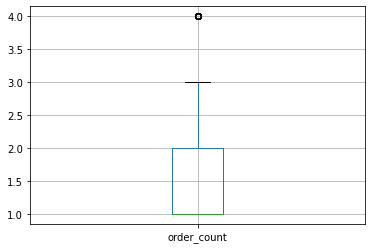

In [132]:
demand_df.boxplot(column=['order_count'])

Per demand window start time X market combo, 1 order is the most common occurrence.

In [133]:
#Change time column into format Pandas can read.
demand_df['starts_at'] = pd.to_datetime(demand_df['starts_at'],
                              format='%Y-%m-%dT%H:%M:%SZ')

In [134]:
#Prophet implementation at market level
demand_df = demand_df.rename(columns={'starts_at': 'ds','order_count': 'y', 'market_name': 'market'})
list_markets = demand_df.market.unique()
list_markets

array(['New York NY', 'Philadelphia', 'San Francisco'], dtype=object)

In [135]:
def get_prediction(df):
    prediction = {}
    df = df.rename(columns={'starts_at': 'ds','order_count': 'y', 'market_name': 'market'})
    list_markets = df.market.unique()

    for market in list_markets:
        market_df = df.loc[df['market'] == market]
        # the Prophet default uncertainty interval is 80% (higher % will increase forecast uncertainty)
        my_model = Prophet(weekly_seasonality= True, daily_seasonality=True,seasonality_prior_scale=1.0) #seasonality_prior_scale modulates seasonality influence in modeling
        my_model.fit(market_df)
        future_dates = my_model.make_future_dataframe(periods=30)
        forecast = my_model.predict(future_dates)
        prediction[market] = forecast
        fig1 = my_model.plot(forecast)
        fig2 = my_model.plot_components(forecast)
       
    return fig1
    return fig2

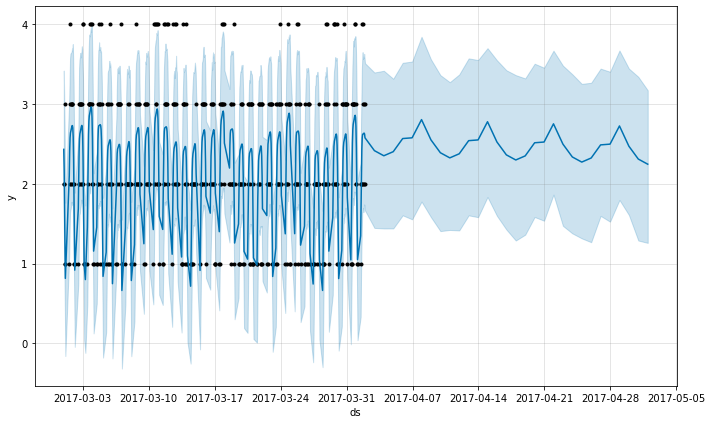

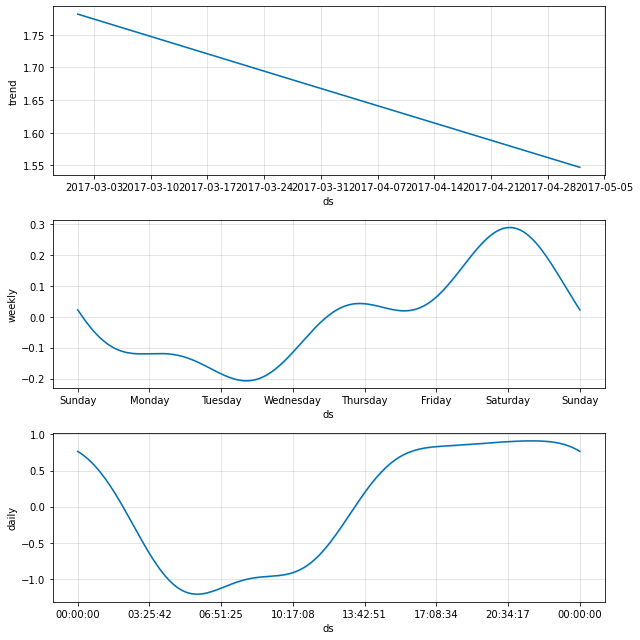

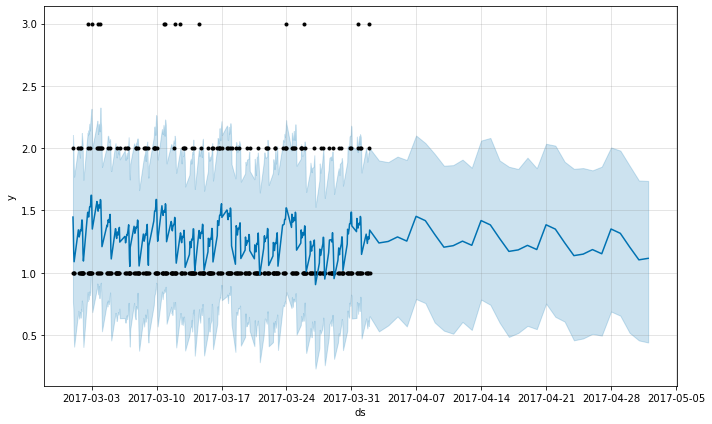

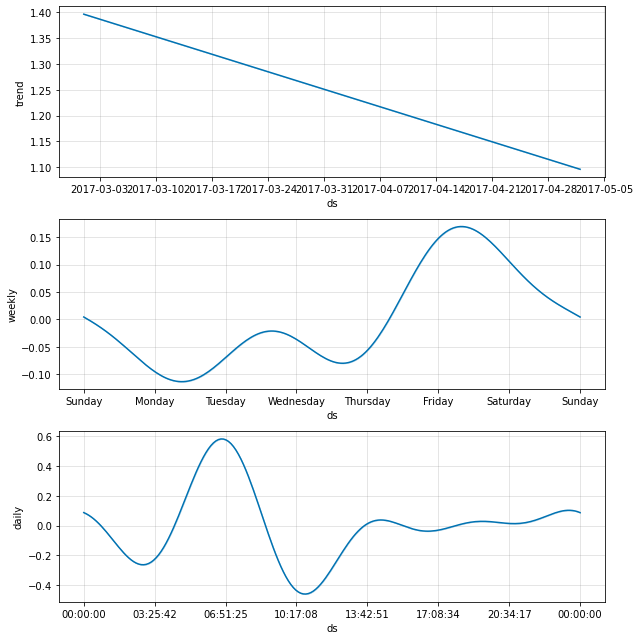

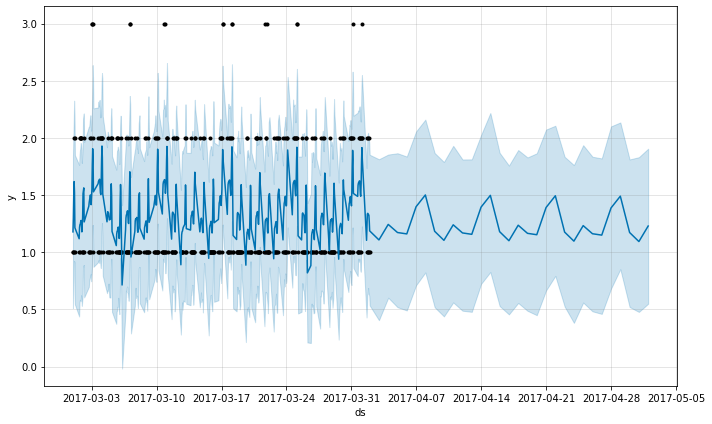

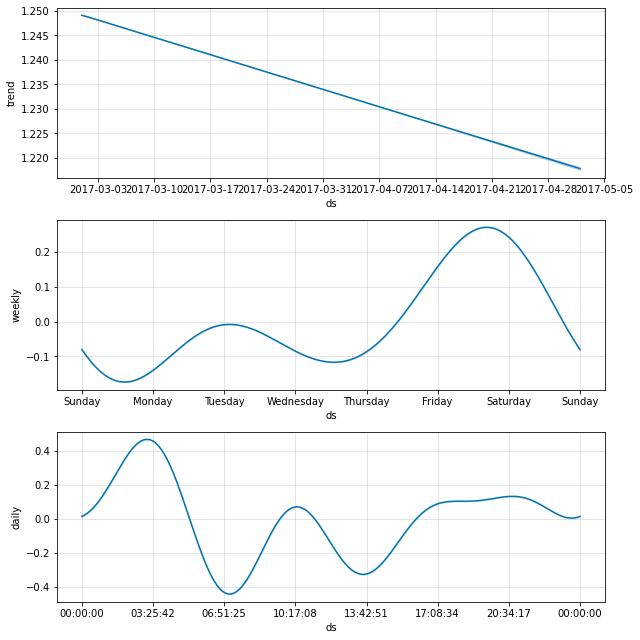

In [136]:
forecast_data = get_prediction(demand_df)

Some observations:

* New York's predictions are optimistic with 2 to 3 orders predicted to be in the horizon whereas in the other markets- Phili and SF- predictions were on the lower end. SF's predictions' trend compared to Phili's is more variable day-to-day.

* All markets had downward trend from historical data start point (early March) to prediction end date (earky May).

* On a weekly basis, New York starts its demand on low end and then picks up on Wednesday and afterward with a spike on Saturday before dipping. For Phili and SF, only pick up is from Thursday to Saturday.

* On a daily basis, for NY market, lowest supply is from 3:30 am to 10 am then there is a pick up in order at noon and then plateaus. For Phili market, demand peaks little before 7 am. And for SF, peaks at 3 am with way more fluctuations and then plateauing after 5 pm. 

In [137]:
prediction = {}
for market in list_markets:
    market_df = demand_df.loc[demand_df['market'] == market]
    # Prophet default uncertainty interval is 80% (higher % will increase forecast uncertainty)
    my_model = Prophet(weekly_seasonality= True, daily_seasonality=True,seasonality_prior_scale=1.0) #seasonality_prior_scale modulates seasonality influence in modeling
    my_model.fit(market_df)
    future_dates = my_model.make_future_dataframe(periods=30)
    forecast = my_model.predict(future_dates)
    prediction[market] = forecast

    #   Diagnostics
    df_cv = cross_validation(my_model, initial = '20 days', horizon= '10 days')
    df_pm = performance_metrics(df_cv)
df_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days 00:00:00,0.371910,0.609844,0.546153,0.373258,0.390624,0.727273
1,1 days 01:00:00,0.275426,0.524810,0.474448,0.350059,0.356121,0.818182
2,1 days 02:00:00,0.229027,0.478568,0.442315,0.333993,0.287502,0.909091
3,1 days 03:00:00,0.224881,0.474216,0.435847,0.314571,0.278394,0.909091
4,1 days 04:00:00,0.263918,0.513729,0.462828,0.367689,0.278394,0.818182
...,...,...,...,...,...,...,...
103,9 days 20:00:00,0.527898,0.726566,0.627614,0.326969,0.351461,0.545455
104,9 days 21:00:00,0.499728,0.706914,0.596159,0.323731,0.351461,0.545455
105,9 days 22:00:00,0.449888,0.670737,0.545438,0.308023,0.274776,0.636364
106,9 days 23:00:00,0.470995,0.686291,0.557647,0.314127,0.274776,0.636364


In [138]:
df_pm['mae'].min(), df_pm['mae'].max()

(0.24812269095217987, 0.6782712918283452)

# Supply at Market Level

In [139]:
supply_df = ps.sqldf("select starts_at, market_name, count(distinct shopper_id) as avail_unique_shoppers from df where abandoned = 0 group by 1, 2")
supply_df

,starts_at,market_name,avail_unique_shoppers
0,2017-03-01T00:00:00Z,New York NY,1
1,2017-03-01T00:00:00Z,Philadelphia,1
2,2017-03-01T00:00:00Z,San Francisco,1
3,2017-03-01T01:00:00Z,New York NY,2
4,2017-03-01T01:00:00Z,Philadelphia,1
...,...,...,...
933,2017-04-01T22:00:00Z,Philadelphia,2
934,2017-04-01T22:00:00Z,San Francisco,1
935,2017-04-01T23:00:00Z,New York NY,2
936,2017-04-01T23:00:00Z,Philadelphia,1


In [140]:
supply_df['avail_unique_shoppers'].value_counts()

1    734
2    185
3     19
Name: avail_unique_shoppers, dtype: int64

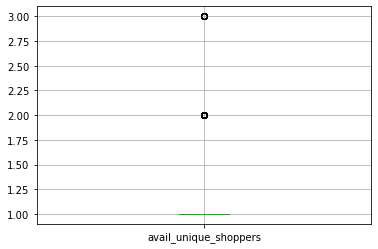

In [141]:
supply_df.boxplot(column=['avail_unique_shoppers'])

Mostly 1 unique shopper available per delivery window x market combo.

In [142]:
supply_df['starts_at'] = pd.to_datetime(supply_df['starts_at'],
                              format='%Y-%m-%dT%H:%M:%SZ')

In [143]:
supply_df = supply_df.rename(columns={'starts_at': 'ds','avail_unique_shoppers': 'y', 'market_name': 'market'})
list_markets = supply_df.market.unique()
list_markets

array(['New York NY', 'Philadelphia', 'San Francisco'], dtype=object)

In [144]:
def get_prediction(df):
    prediction = {}
    df = df.rename(columns={'starts_at': 'ds','avail_unique_shoppers': 'y', 'market_name': 'market'})
    list_markets = df.market.unique()

    for market in list_markets:
        market_df = df.loc[df['market'] == market]
        # the Prophet default uncertainty interval is 80% (higher % will increase forecast uncertainty)
        my_model = Prophet(weekly_seasonality= True, daily_seasonality=True,seasonality_prior_scale=1.0) #seasonality_prior_scale modulates seasonality influence in modeling
        my_model.fit(market_df)
        future_dates = my_model.make_future_dataframe(periods=30)
        forecast = my_model.predict(future_dates)
        prediction[market] = forecast
        fig1 = my_model.plot(forecast)
        fig2 = my_model.plot_components(forecast)
       
    return list_markets #only renders last 2 requests (list_markets not in output)
    return fig1
    return fig2

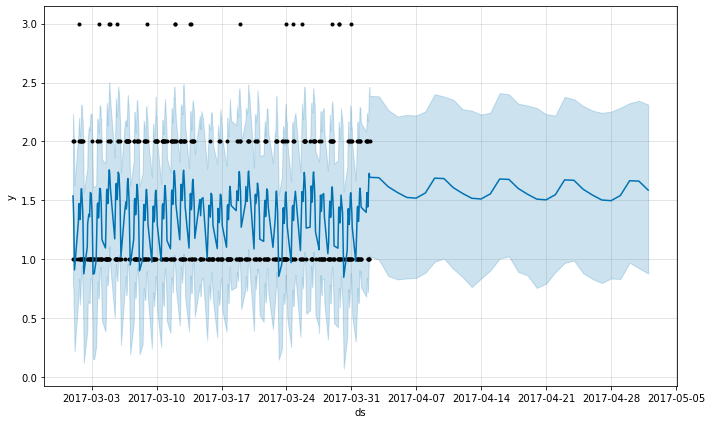

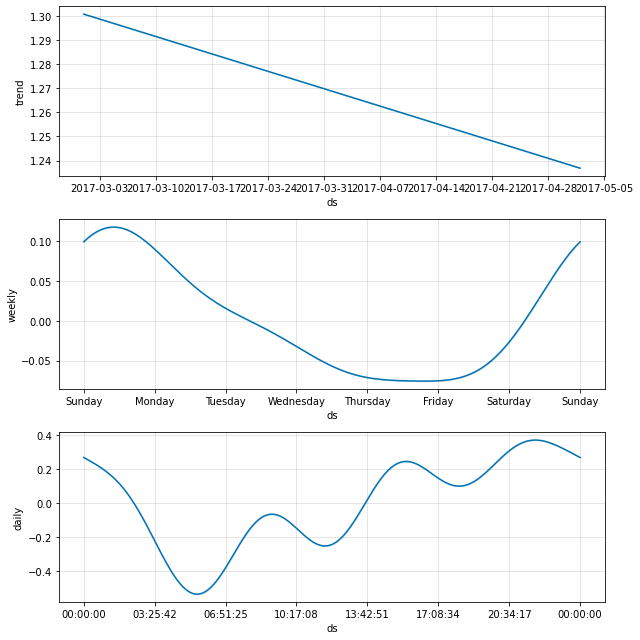

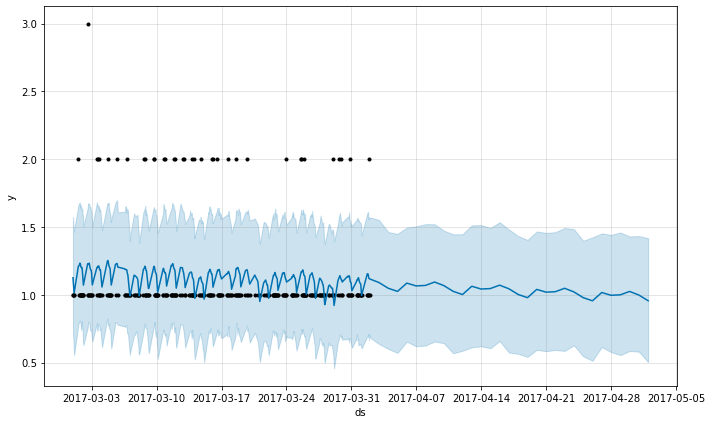

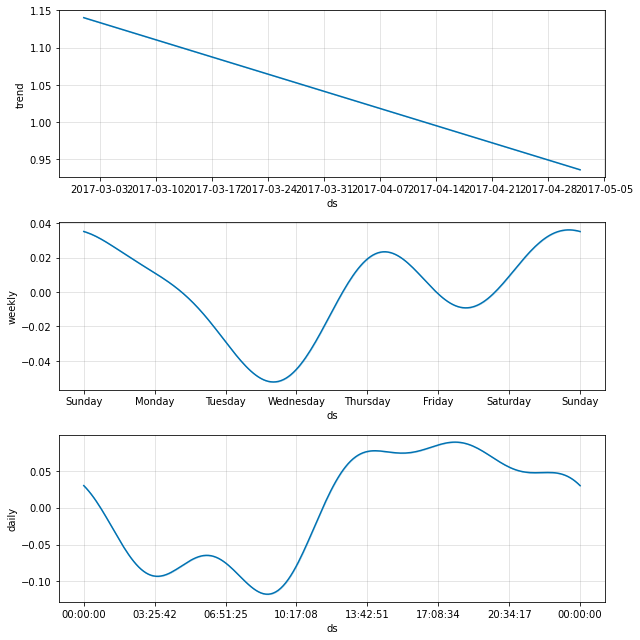

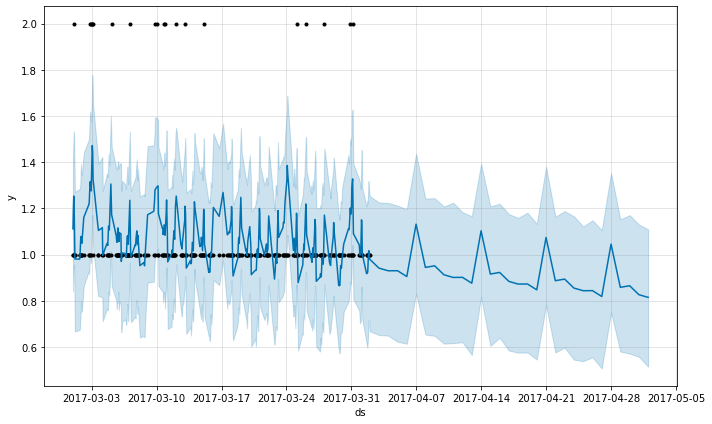

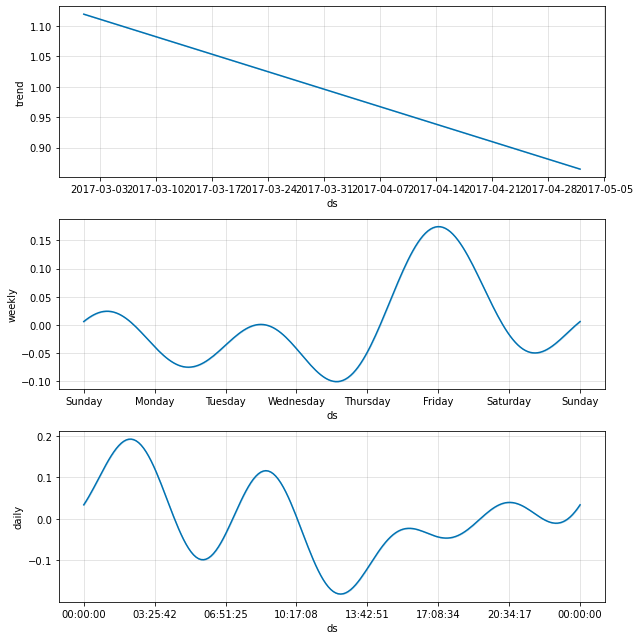

In [145]:
forecast_data = get_prediction(supply_df)

Some observations:

* New York market's supply predictions are on high end (= Demand) whereas Phili's supply has low variance and has a downward trend in forecast. On the other hand, SF's historical trend is highly variable, but not huge in range when it comes to number of shoppers available to fulfill orders.

* Forecast trend for all markets is a downward trend which maches demand's trend as well.

* On a weekly basis, highest supply is on weekends which does not match NY's demand. (Incentive for shoppers needs to be rolled out to help with supply-demand equilibrium). Phili's supply has some overlap with its demand forecast but Sunday is not covered, which is loss in Revenue. For SF there is an even greater mismatch since most of the supply is on Fri coverage is needed before and after Fri.

* On a daily basis, New York has supply that fluctuates but has an upward trend starting around 7 am which causes oversupply of shoppers since demand is not forecasted until 12 pm. For Phili, most shoppers clock in around 10 am which is delayed response (loss in revenue). For SF market, highest supply is before 3:30 am and between 7 and 10:15 am and lowest amount of shoppers is around 1 pm. This is in line with the demand -- only occurrence of supply-demand equilibrium- yay for at least one and not none!

In [146]:
prediction = {}
for market in list_markets:
    market_df = supply_df.loc[supply_df['market'] == market]
    # Prophet default uncertainty interval is 80% (higher % will increase forecast uncertainty)
    my_model = Prophet(weekly_seasonality= True, daily_seasonality=True,seasonality_prior_scale=1.0) #seasonality_prior_scale modulates seasonality influence in modeling
    my_model.fit(market_df)
    future_dates = my_model.make_future_dataframe(periods=30)
    forecast = my_model.predict(future_dates)
    prediction[market] = forecast

    # Diagnostics
    df_cv = cross_validation(my_model, initial = '20 days', horizon= '10 days')
    df_pm = performance_metrics(df_cv)
df_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days 02:00:00,0.060323,0.245607,0.224381,0.224381,0.205964,0.875
1,1 days 03:00:00,0.082637,0.287467,0.256701,0.256701,0.223142,0.750
2,1 days 04:00:00,0.103444,0.321628,0.300214,0.300214,0.269020,0.625
3,1 days 19:00:00,0.099748,0.315829,0.281560,0.281560,0.269020,0.625
4,1 days 20:00:00,0.096374,0.310441,0.266720,0.266720,0.269020,0.625
...,...,...,...,...,...,...,...
74,9 days 20:00:00,0.012652,0.112481,0.101441,0.101441,0.109342,1.000
75,9 days 21:00:00,0.012956,0.113825,0.106288,0.106288,0.109342,1.000
76,9 days 22:00:00,0.011214,0.105897,0.096999,0.096999,0.077838,1.000
77,9 days 23:00:00,0.011519,0.107326,0.099106,0.099106,0.084273,1.000


In [147]:
df_pm['mae'].min(), df_pm['mae'].max()

(0.052102983520448454, 0.3550284898527738)

At market level, model for supply forecasts did much better than model for demand forecasts.

# Spatial Hierarchical Time Series Forecasting

This sort of forecasting incorporates data from neighborhoods that are nested within markets.

In [148]:
!pip install htsprophet

Source for htsprophet: https://github.com/CollinRooney12/htsprophet

In [149]:
from htsprophet.hts import hts, orderHier, makeWeekly
from htsprophet.htsPlot import plotNode, plotChild, plotNodeComponents

In [150]:
#Need df to be in this format: start_at--market-neighborhood--order_count/shopper_count
demand

,starts_at,market_name,neighborhood_name,count(order_id)
0,2017-03-01T00:00:00Z,New York NY,Staten Island,1
1,2017-03-01T00:00:00Z,New York NY,Upper East Side,1
2,2017-03-01T00:00:00Z,Philadelphia,Chestnut Hill,1
3,2017-03-01T00:00:00Z,Philadelphia,Philadelphia West,1
4,2017-03-01T00:00:00Z,San Francisco,Financial District,1
...,...,...,...,...
2084,2017-04-01T23:00:00Z,New York NY,Downtown Brooklyn,1
2085,2017-04-01T23:00:00Z,New York NY,Staten Island,1
2086,2017-04-01T23:00:00Z,New York NY,Upper West Side,1
2087,2017-04-01T23:00:00Z,Philadelphia,Philadelphia West,1


In [151]:
supply

,starts_at,market_name,neighborhood_name,count(distinct shopper_id)
0,2017-03-01 00:00:00,New York NY,Staten Island,1
1,2017-03-01 00:00:00,Philadelphia,Chestnut Hill,1
2,2017-03-01 00:00:00,Philadelphia,Philadelphia West,1
3,2017-03-01 00:00:00,San Francisco,Financial District,1
4,2017-03-01 01:00:00,New York NY,Downtown Brooklyn,1
...,...,...,...,...
1353,2017-04-01 22:00:00,San Francisco,SoMa / Castro,1
1354,2017-04-01 23:00:00,New York NY,Downtown Brooklyn,1
1355,2017-04-01 23:00:00,New York NY,Staten Island,1
1356,2017-04-01 23:00:00,Philadelphia,Philadelphia West,1


In [152]:
supply2 = ps.sqldf("select starts_at, market_name, neighborhood_name,count(distinct shopper_id) distinct_shop_count from df where abandoned = 0 group by 1, 2, 3")
ps.sqldf("select* from supply2 where distinct_shop_count != 1")

,starts_at,market_name,neighborhood_name,distinct_shop_count


No output above proves that the data is not rich enough. As a reminder we only have one month's worth of data and this does not help with broad horizon forecasting. In order to proceed with htsprophet forecasting will make a similar dataset using synthetic data generator.

Some similarities with this dataset is that it has similar time frame. Though some differences/caveats are that market/neighborhood got changes to market/city levels. And the dataset is only 1000 rows. Given, there cannot be 1:1 comparison in forecast accuracy between htsprophet and prior models given different datasets. However, this is still illustrative of ability to do forecasts on hierarchical data.

In [153]:
df2 = pd.read_csv("../input/mock-data/MOCK_DATA.csv")
df2

,start_at,market_name,neighborhood_name,orders_count,distinct_count_fulfilled_shoppers
0,2017-03-08T18:53:58Z,California,Inglewood,1,6
1,2017-03-27T23:20:20Z,California,Los Angeles,2,6
2,2017-03-22T21:35:16Z,California,Stockton,3,1
3,2017-03-23T06:13:34Z,Pennsylvania,Bethlehem,3,6
4,2017-03-30T09:23:39Z,California,Sacramento,4,3
...,...,...,...,...,...
995,2017-03-29T18:00:03Z,Pennsylvania,Lancaster,3,3
996,2017-03-16T20:34:06Z,Pennsylvania,Philadelphia,3,5
997,2017-03-01T06:56:06Z,California,Sacramento,2,1
998,2017-03-31T17:22:40Z,California,Santa Barbara,2,1


In [154]:
#Format time column.
df2["start_at"] = pd.to_datetime(df2['start_at'],
                              format='%Y-%m-%dT%H:%M:%SZ')

## Let's start hierarchical time series forecasting with Demand data

In [155]:
demand_df2 = df2.iloc[:,:-1]
demand_df2

,start_at,market_name,neighborhood_name,orders_count
0,2017-03-08 18:53:58,California,Inglewood,1
1,2017-03-27 23:20:20,California,Los Angeles,2
2,2017-03-22 21:35:16,California,Stockton,3
3,2017-03-23 06:13:34,Pennsylvania,Bethlehem,3
4,2017-03-30 09:23:39,California,Sacramento,4
...,...,...,...,...
995,2017-03-29 18:00:03,Pennsylvania,Lancaster,3
996,2017-03-16 20:34:06,Pennsylvania,Philadelphia,3
997,2017-03-01 06:56:06,California,Sacramento,2
998,2017-03-31 17:22:40,California,Santa Barbara,2


In [156]:
supply_df2 = df2.drop(columns=['orders_count'])
supply_df2

,start_at,market_name,neighborhood_name,distinct_count_fulfilled_shoppers
0,2017-03-08 18:53:58,California,Inglewood,6
1,2017-03-27 23:20:20,California,Los Angeles,6
2,2017-03-22 21:35:16,California,Stockton,1
3,2017-03-23 06:13:34,Pennsylvania,Bethlehem,6
4,2017-03-30 09:23:39,California,Sacramento,3
...,...,...,...,...
995,2017-03-29 18:00:03,Pennsylvania,Lancaster,3
996,2017-03-16 20:34:06,Pennsylvania,Philadelphia,5
997,2017-03-01 06:56:06,California,Sacramento,1
998,2017-03-31 17:22:40,California,Santa Barbara,1


In [157]:
df3, nodes = orderHier(demand_df2,1,2)
df3

,time,Total,California,Pennsylvania,New York,California_Inglewood,California_Los Angeles,California_Stockton,California_Bethlehem,California_Sacramento,...,New York_New Castle,New York_Palo Alto,New York_Fullerton,New York_Port Washington,New York_San Luis Obispo,New York_Carlsbad,New York_Hicksville,New York_Santa Ana,New York_Alhambra,New York_San Rafael
0,2017-03-08 18:53:58,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2017-03-27 23:20:20,2,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2017-03-22 21:35:16,3,3.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2017-03-23 06:13:34,3,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2017-03-30 09:23:39,4,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,2017-03-29 18:00:03,3,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
995,2017-03-16 20:34:06,3,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
996,2017-03-01 06:56:06,2,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
997,2017-03-31 17:22:40,2,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [159]:
nodes = [[3], [97, 99, 98]]

In [160]:
df3.shape

(999, 299)

In [161]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Columns: 299 entries, time to New York_San Rafael
dtypes: datetime64[ns](1), float64(297), int64(1)
memory usage: 2.3 MB


In [162]:
#OLS-optimal combination using ordinary least squares (default) used for forecasting method, freq = daily (default) 
myDict = hts(df3, 30, nodes)
myDict

TypeError: '<' not supported between instances of 'str' and 'int'

There's something broken with hts() code. Using saved df3 in another hts package -- scikit-hts!

In [163]:
!pip install scikit-hts

All that is needed to implement hts in scikit-hts is the DF (with slight modification) and hierarchical structure. So let's get started!

In [165]:
#Moving total to end of DF
df3 = df3[[c for c in df3 if c not in ['Total']] 
       + ['Total']]
df3

,time,California,Pennsylvania,New York,California_Inglewood,California_Los Angeles,California_Stockton,California_Bethlehem,California_Sacramento,California_Simi Valley,...,New York_Palo Alto,New York_Fullerton,New York_Port Washington,New York_San Luis Obispo,New York_Carlsbad,New York_Hicksville,New York_Santa Ana,New York_Alhambra,New York_San Rafael,Total
0,2017-03-08 18:53:58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,2017-03-27 23:20:20,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
2,2017-03-22 21:35:16,3.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3
3,2017-03-23 06:13:34,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3
4,2017-03-30 09:23:39,4.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,2017-03-29 18:00:03,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3
995,2017-03-16 20:34:06,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3
996,2017-03-01 06:56:06,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
997,2017-03-31 17:22:40,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2


In [195]:
#Putting hierarchy together
markets = demand_df2.market_name.unique()
last_level = {'total' : list(markets)}
for m in markets:
    for n in list(df3):
        last_level[m] = [n for n in list(df3) if n.startswith(m)]
last_level

{'total': ['California', 'Pennsylvania', 'New York'],
 'California': ['California',
  'California_Inglewood',
  'California_Los Angeles',
  'California_Stockton',
  'California_Bethlehem',
  'California_Sacramento',
  'California_Simi Valley',
  'California_Albany',
  'California_Modesto',
  'California_San Francisco',
  'California_Lancaster',
  'California_York',
  'California_Oakland',
  'California_Irvine',
  'California_San Jose',
  'California_Chula Vista',
  'California_Mountain View',
  'California_San Diego',
  'California_North Hollywood',
  'California_White Plains',
  'California_New York City',
  'California_Santa Cruz',
  'California_Hayward',
  'California_Erie',
  'California_Harrisburg',
  'California_Buffalo',
  'California_Whittier',
  'California_Philadelphia',
  'California_Torrance',
  'California_Bakersfield',
  'California_Salinas',
  'California_Bronx',
  'California_Pittsburgh',
  'California_Great Neck',
  'California_Long Beach',
  'California_Mount Vernon',

In [193]:
# ht = HierarchyTree.from_nodes(hier, df3)
# ht